#### 분산 강화학습으로 CartPole을 DQN을 이용하여 구현해보겠습니다. <br>기본적인 방식은 다음과 같습니다. <br>  
    1. Replay Buffer: Actor로부터 data를 받고, Learner에게 data를 전달하는 역할
    2. Parameter Server: Learner로부터 parameter를 받고, Actor에게 paramter를 전달하는 역할.
    3. Learner: Replay Buffer로 부터 데이터를 받아 학습을 진행하고, Parameter Server로 Learner 모델의 parameter를 전달하는 역할.
    4. Actor: Environment와 상호작용하며 data를 Replay Buffer에 전달하고, Parameter Server로부터 Learner 모델의 parameter를 받아 자신의 모델 parameter를 update.

#### ISSUE<br>

    cuda가 process에 올려진 객체를 ray.remote가 선언된 class의 변수로 전달할 경우, 에러가 발생합니다. 
    그래서 예를들어 Q-network은 @ray.remote로 데코레이션을 하지 않습니다. 마찬가지 이유로, Learner 또한 ray.remote를 하지 않습니다.

In [ ]:
import ray 
import gym
import time 
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output

import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
ray.init() 

In [ ]:
# Buffer를 정의합니다. 
@ray.remote 
class ReplayBuffer:
    def __init__(self, 
                   buffer_size: ('int: Buffer_size'), 
                 state_dim: ('tuple: State dim')):

        # 1차원 state라할지라도 tuple로 입력받도록 tuple 타입을 강제하였습니다. 
        # 밑에 줄의 self.buffer_dim을 구하기 위해서 이렇게 한 것인데요, 사실 빼도 상관없고 얼마든지 다르게 구현해도 무방합니다.
        # 참고) ray를 쓸 때는, class선언시에 assert조건을 만족못하여도 에러를 주지 않습니다. class의 메소드를 실행하고나서야 __init__에서 assertion 에러가 있다고 표시를 합니다. 
        assert type(state_dim) == tuple
        
        self.buffer_dim = (buffer_size, ) + state_dim
        self.buffer_size = buffer_size
        self.state_buffer = np.zeros(self.buffer_dim)
        self.action_buffer = np.zeros(buffer_size)
        self.reward_buffer = np.zeros(buffer_size)
        self.next_state_buffer = np.zeros(self.buffer_dim)
        self.done_buffer = np.zeros(buffer_size)
        self.act_idx_buffer = np.zeros(buffer_size)

        self.store_idx = 0
        self.current_size = 0
        self.total_store_count = 0

    def store(self, state, action, next_state, reward, done, actor_idx): 
        # actor_idx는 쓰이지 않지만, 중간에 데이터 저장이 잘 되는지 확인용 변수
        self.state_buffer[self.store_idx] = state
        self.action_buffer[self.store_idx] = action
        self.reward_buffer[self.store_idx] = reward
        self.next_state_buffer[self.store_idx] = next_state
        self.done_buffer[self.store_idx] = done
        self.act_idx_buffer[self.store_idx] = actor_idx
        
        self.total_store_count += 1 # used for counting the total number of steps during training
        self.store_idx = (self.store_idx + 1) % self.buffer_size
        self.current_size = min(self.current_size+1, self.buffer_size)
    
    def batch_load(self, batch_size): 
        indices = np.random.randint(self.current_size, size=batch_size)  
        return dict( 
                states=self.state_buffer[indices], 
                actions=self.action_buffer[indices], 
                rewards=self.reward_buffer[indices], 
                next_states=self.next_state_buffer[indices], 
                dones=self.done_buffer[indices],
                actindices=self.act_idx_buffer[indices])  
    
    # 아래의 메소드들은 ray로 다른 객체가 current_size, store_idx, total_store_count 변수들을 접근할 때 쓰기 위해서 선언
    def return_current_size(self):
        return self.current_size

    def return_store_idx(self):
        return self.store_idx

    def return_total_store_count(self):
        return self.total_store_count
    
# # test
# buffer_size = 1000
# batch_size = 16
# state_dim = (4, )
# temp_buffer = ReplayBuffer.remote(buffer_size, state_dim)

# for i in range(50):
#     temp_buffer.store.remote(np.array(state_dim), 1, np.array(state_dim), 1, 1, 1)

# batch = temp_buffer.batch_load.remote(batch_size)
# print("Batch Size:", ray.get(batch)['actindices'].shape) 

# current_size = temp_buffer.return_current_size.remote()
# print("Current Size: ", ray.get(current_size))

# return_store_idx = temp_buffer.return_store_idx.remote()
# print("Store Index: ", ray.get(return_store_idx))

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden=32):
        super(QNetwork, self).__init__()

        state_size = state_size[0]
        self.fc1 = nn.Linear(state_size, hidden)
        self.fc2 = nn.Linear(hidden, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# state_size = (4, ) 
# action_size = 2 
# temp_net = QNetwork(state_size, action_size, 32) 
# test = torch.randn(size=(4,)) 
# temp_net(test), temp_net(test).shape 

In [ ]:
@ray.remote
class Network_parameter_server:
    def __init__(self): 
        self.is_saved = False # 언제부터 actor가 모델 parameter를 가지고 올 수 있는지 확인하는 변수
        
    def update_parameters(self, learner_params): 
        self.learner_params = learner_params
        self.is_saved = True

    def return_parameters(self):
        self.is_saved = False
        return self.learner_params
        
    def return_saving_status(self):
        return self.is_saved

In [ ]:
# actor의 역할은 각각 env에서 경험한 것을 buffer에 넘겨주는 역할을 합니다.
@ray.remote
class Actor:  
    def __init__(self, 
                 params_server: ("Class: Network parameter server"),
                 memory: ("class: Replay Buffer"),
                 env_name: ("str: Environment name"), 
                 actor_idx: ("int: The index of an actor"), 
                 epsilon: ("int: starting epsilon value for e-greedy update"), 
                 eps_decay: ("int: epsilon decay rate"), 
                 eps_min: ("int: minimum epsilon value"), 
                 hidden: ("int: Update frequency of learner's q_behave network"), 
                 device: ("int: Cuda device number"),
                 is_wandb: ("str: Whether wandb is on or off"),
                 plot_mode: ("str: whether to plot in wandb or inline in jupyter"),
                 WANDB_GROUP_NAME: ("str: Wandb's group name for all actors")):

        # wandb init config 
        if is_wandb:
            entity = 'rl_flip_school_team'  
            project_name = 'Distributed_DQN'
            wandb.init(
                    group=WANDB_GROUP_NAME,
                    project=project_name, 
                    entity=entity,
                    name=f'{actor_idx}_Distributed_DQN'
                    ) 

        self.env = gym.make(env_name)
        self.params_server = params_server
        self.memory = memory   # ray를 통해 공유하는 Replaybuffer class입니다.
        self.actor_idx = actor_idx # 어떤 actor에서 온 데이터인지 보기 위한 변수입니다.
        self.plot_mode = plot_mode
        self.device = device

        # DQN hyperparameters
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min

        # Network parameters
        self.state_dim = (self.env.observation_space.shape[0], )
        try: self.action_dim = self.env.action_space.n # Discrete action
        except: self.action_dim = env.action_space.shape[0] # Continous action            
        self.q_behave = QNetwork(self.state_dim, self.action_dim, hidden).to(self.device)

    def select_action(self, state): 
        # e-greedy로 action을 선택 
        if np.random.random() < self.epsilon: 
            return np.zeros(self.action_dim), self.env.action_space.sample() 
        else: 
            state = torch.FloatTensor(state).to(self.device).unsqueeze(0) 
            Qs = self.q_behave(state) 
            action = Qs.argmax() 
            return Qs.detach().cpu().numpy(), action.detach().item() 
        
    def explore(self):
        score = 0
        state = self.env.reset()

        # actor는 멈추지 않고 무한 loop로 exploration하도록 설정
        while 1:
            Qs, action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action) 
            
            self.memory.store.remote(state, action, next_state, reward, done, self.actor_idx) # 공유 ReplayBuffer에 저장
            
            score += reward
            state = next_state
            self.epsilon = max(self.epsilon-self.eps_decay, self.eps_min)
            if done:
                state = self.env.reset() 
                self._plot_status(score)
                score = 0
                buffer_status = ray.get(self.params_server.return_saving_status.remote())
                if buffer_status: self._pull_parameters() 

    def _pull_parameters(self):
        updated_params = ray.get(self.params_server.return_parameters.remote()) 
        self.q_behave.load_state_dict(updated_params) 

    def _plot_status(self, score):
        if self.plot_mode=='wandb':
            wandb.log({'Score': score, 
                       f'Score_{self.actor_idx}': score}, step=ray.get(self.memory.return_total_store_count.remote())) 

In [1]:
import ray
import numpy as np
import matplotlib.pyplot as plt
ray.init() 

2021-01-29 12:22:12,544	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.0.61',
 'raylet_ip_address': '192.168.0.61',
 'redis_address': '192.168.0.61:51760',
 'object_store_address': '/tmp/ray/session_2021-01-29_12-22-11_640725_61040/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_12-22-11_640725_61040/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-01-29_12-22-11_640725_61040',
 'metrics_export_port': 64611,
 'node_id': 'a533cab9e8c14ffa8bf131a77461560d14ee5a58'}

In [2]:
@ray.remote
class Test:
    def __init__(self, plot_inline):
        self.plot_inline = plot_inline
        print(id(self.plot_inline)) 
    def gen_data(self):
        for _ in range(4):
            score = np.random.randn() 
            self.plot_inline.store_data(score) 

In [3]:
class Plot_inline:
    def __init__(self):
        globals()['scores'] = []

    def plotting_inline(self):
        plt.figure(facecolor='w')
        plt.plot(scores) 
        plt.show() 

    def store_data(self, score):
        scores.append(score)      
        print(scores)
        print(score) 

In [4]:
plot_inline = Plot_inline()   
test = Test.remote(plot_inline)  

(pid=61201) 140237806089888


In [5]:
id(plot_inline) 

140025322169176

In [6]:
test.gen_data.remote() 

ObjectRef(cb230a572350ff44df5a1a820100000001000000)

(pid=61201) [0.7562328978135184]
(pid=61201) 0.7562328978135184
(pid=61201) [0.7562328978135184, 0.7444665207728387]
(pid=61201) 0.7444665207728387
(pid=61201) [0.7562328978135184, 0.7444665207728387, -0.9556071794407452]
(pid=61201) -0.9556071794407452
(pid=61201) [0.7562328978135184, 0.7444665207728387, -0.9556071794407452, 0.08973416355236462]
(pid=61201) 0.08973416355236462


In [12]:
plot_inline.store_data(100)  

[100, 100, 100, 100, 100]
100


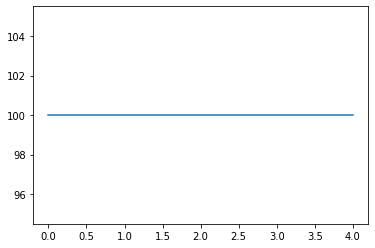

In [13]:
plot_inline.plotting_inline() 

In [ ]:
# Learner는 buffer에 있는 샘플을 이용하여 network parameter를 업데이트를 하며, parameter server에 network weight을 전달합니다.
# Learner는 network update 등 cuda 연산을 하고 cpu로 병렬처리하는 것이 없으므로, 즉 ray를 이용할 필요가 없으므로, @ray.remote를 활용하지 않습니다.
class Learner: 
    def __init__(self, 
                 env_name: ("str: Environment name"),
                 params_server: ("Class: Network parameter server"),
                 memory: ("class: ReplayBuffer"),
                 gamma: ("float: Discount rate"),
                 update_buf_start: ("int: Update starting buffer size"), 
                 update_freq: ("int: Frequency of updating learner's q_behave network"), 
                 update_target_freq: ("int: Frequency of updating learner's q_target network"), 
                 update_push_freq: ("int: Frequency of sending learner's paratemers to parameter-server"), 
                 hidden: ("int: Update frequency of learner's q_behave network"), 
                 batch_size: ("int: Batch size for updating network"),
                 learning_rate: ("float: Learning rate for updating the q_behave network"),
                 device: ("int: Cuda device number"),
                 is_wandb: ("str: Whether wandb is on or off"),
                 plot_mode: ("str: whether to plot in wandb or inline in jupyter"),
                 WANDB_GROUP_NAME: ("str: Wandb's group name for all actors")):
                    
        if is_wandb:
            entity = 'rl_flip_school_team'  
            project_name = 'Distributed_DQN'
            wandb.init(
                    group=WANDB_GROUP_NAME,
                    project=project_name, 
                    entity=entity,
                    name='Learner_Distributed_DQN'
                    ) 

        self.env = gym.make(env_name)
        self.params_server = params_server
        self.memory = memory
        self.gamma = gamma
        self.plot_mode = plot_mode
        
        self.state_dim = (self.env.observation_space.shape[0], )
        try: self.action_dim = self.env.action_space.n # Discrete action
        except: self.action_dim = env.action_space.shape[0] # Continous action 
            
        self.batch_size = batch_size
        self.update_cnt = 0 # q_behave 업데이트 횟수
        self.update_freq = update_freq # q_behave 업데이트 주기
        self.update_buf_start = update_buf_start # 업데이트 시작 buffer size
        self.update_target_freq = update_target_freq # q_target 업데이트 주기
        self.update_push_freq = update_push_freq # parameter server에 보내는 주기
        self.device = device
        self.total_steps = 0
        self.scores = []
        self.losses = [0]

        self.q_behave = QNetwork(self.state_dim, self.action_dim, hidden).to(self.device)
        self.q_target = QNetwork(self.state_dim, self.action_dim, hidden).to(self.device)
        self.q_target.load_state_dict(self.q_behave.state_dict())
        self.q_target.eval()

        self.optimizer = optim.Adam(self.q_behave.parameters(), lr=learning_rate) 

    # 저장된 buffer에서 데이터를 로딩한 후 q_network을 업데이트합니다.
    def update_q_network(self):
        # update_cnt를 q_behave를 업데이트 할 때마다 1씩 상승 (self.update_target_freq 만큼 q_behave를 업데이트를 할 때마다 q_target을 업데이트 하기 위함)
        self.update_cnt += 1
        batch = ray.get(self.memory.batch_load.remote(self.batch_size)) 
        loss = self._compute_loss(batch) 

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.item()) # for plotting the losses

    def target_hard_update(self):  
        # Hard update 방식
        self.q_target.load_state_dict(self.q_behave.state_dict()) 

    def eval_select_action(self, state): 
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0) 
        Qs = self.q_behave(state) 
        action = Qs.argmax() 
        return Qs.detach().cpu().numpy(), action.detach().item() 

    def push_parameters(self):
        # Send paramters to server 
        copied_model = deepcopy(self.q_behave).cpu()
        self.params_server.update_parameters.remote(copied_model.state_dict())

    def train(self):
        # 여기서는 training의 종료시점을 정하지 않았습니다.
        print("training start..")
        while 1:
            self.update_q_network()
#             learner_score = self.eval() 
            learner_score = 0
            self._plot_status(learner_score)

            # 만일 update_push_freq 횟수 만큼 q_behave를 업데이트 했다면, server에 parameter를 보냅니다.
            if (self.update_cnt%self.update_push_freq)==0: self.push_parameters()

            # 만일 target_update_freq의 횟수 만큼 q_behave를 업데이트 했다면, target_network을 복사해옵니다.
            if (self.update_cnt%self.update_target_freq)==0: self.target_hard_update()
                
    def eval(self):
        score = 0
        state = self.env.reset()
        while 1:
            Qs, action = self.eval_select_action(state)
            next_state, reward, done, _ = self.env.step(action) 
            score += reward
            state = next_state
            if done: break
        return score

    def _compute_loss(self, batch: "Dictionary (S, A, R', S', Dones)"):
        states = torch.FloatTensor(batch['states']).to(self.device)
        next_states = torch.FloatTensor(batch['next_states']).to(self.device)
        actions = torch.LongTensor(batch['actions'].reshape(-1, 1)).to(self.device)
        rewards = torch.FloatTensor(batch['rewards'].reshape(-1, 1)).to(self.device)
        dones = torch.FloatTensor(batch['dones'].reshape(-1, 1)).to(self.device)
        
        current_q = self.q_behave(states).gather(1, actions)
        next_q = self.q_target(next_states).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - dones
        target = (rewards + (mask * self.gamma * next_q)).to(self.device)
        loss = F.smooth_l1_loss(target, current_q)
        
        return loss

    def _plot_status(self, score=0):
        if self.plot_mode=='wandb':
            wandb.log({"Learner Score": score, 
                       "loss(10 frames avg)": np.mean(self.losses[-10:])
                      }, step=ray.get(self.memory.return_total_store_count.remote()))
            
#         if mode=='inline':
#             clear_output(True)
            
#             subplot_params = [
#                 (121, f"Scores in episode_{i_episode}", score_hist),
#                 (122, f"Policy loss in episode:{i_episode}", loss_hist),
#             ] self.total_store_cnt
            
#             plt.figure(figsize=(10, 5), facecolor='w')
#             for loc, title, values in subplot_params:
#                 plt.subplot(loc)
#                 plt.title(f'Frame:{self.frame_cnt} '+title)
#                 plt.plot(values)
#             plt.show() 

In [ ]:
env_lists = ['CartPole-v0', 'LunarLander-v2']
env_name = env_lists[0]
gamma = 0.99

buffer_size = 20000 # Replay Buffer 사이즈
batch_size = 64    # Replay Buffer에서 가지고 올 샘플 개수
env = gym.make(env_name)
state_dim = (env.observation_space.shape[0], ) 
        
update_buf_start = 2000
update_freq = 1
update_target_freq = 10
update_push_freq = 1

hidden = 256
learning_rate = 0.00005
learner_device = "cuda:1" if torch.cuda.is_available() else "cpu"
is_wandb = True     # whether to use wandb or not
plot_mode = 'wandb' # plot options: 'wandb' or 'inline'
WANDB_GROUP_NAME = 'Distributed_DQN_' + str(np.random.randint(10000))

params_server = Network_parameter_server.remote() 
memory = ReplayBuffer.remote(buffer_size, state_dim)
learner = Learner(env_name, params_server, memory, gamma, 
                  update_buf_start, update_freq, update_target_freq, update_push_freq, 
                  hidden, batch_size, learning_rate, learner_device, is_wandb, plot_mode, WANDB_GROUP_NAME) 

In [ ]:
# num_actors 개수만큼 선언하고, explore 실행. actor라는 변수가 계속 중복이 되더라도 실행은 잘 된다.
num_actors = 15 # actor의 개수
epsilon = 1.0
eps_decay = 1/5000
eps_min = 0.1
actor_device = "cpu"

for actor_idx in range(num_actors):
    actor = Actor.remote(params_server, memory, env_name, actor_idx, 
                                                   epsilon, eps_decay, eps_min, hidden, actor_device, 
                                                   is_wandb, plot_mode, WANDB_GROUP_NAME)
    actor.explore.remote() 

In [ ]:
while 1:
    buffer_saved_cnt = ray.get(memory.return_total_store_count.remote())
    if buffer_saved_cnt > learner.update_buf_start: learner.train()  